# Set up your environment

Use the mlgeo enviroment from class

Use `requirements.txt` for additional updates

In [182]:
import numpy as np
import h5py
import os, re, glob
import math
from scipy import signal
from scipy.signal import butter, lfilter
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from matplotlib.pyplot import savefig
import seaborn as sns
import time

import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv1D, MaxPooling1D, UpSampling1D, Flatten, Dropout, Reshape 
from tensorflow.keras.layers import Bidirectional, BatchNormalization, ZeroPadding1D, Conv2DTranspose
from tensorflow.keras.layers import Layer, InputSpec
from tensorflow.keras.models import Model

from tensorflow.keras.optimizers import SGD, Adam, schedules

from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau, EarlyStopping, CSVLogger
from tensorflow.keras.initializers import VarianceScaling

sns.set_style('darkgrid')
sns.set_palette('muted')

sns.set_style('darkgrid')
sns.set_palette('muted')

# Load data and split train-test

In [183]:
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

# Step 1: Load data
print("Beginning to load file...")

# Load the seismic data (adjust file path as needed)
data_file = np.load("Input.npy", mmap_mode='r', allow_pickle=True)

# check the data in Input.npy and see if there are any negative values
print(f'Minimum value in data_file: {data_file.min()}')
print(f'Maximum value in data_file: {data_file.max()}')

print('File loaded')

# Step 2: Split data into train and test sets
#print('Split data into training and testing sets')
#train_data, test_data = train_test_split(data_file, test_size=0.2, random_state=46, shuffle=True)

# split the data into train, testing and validation sets NEW
train_data, temp_data = train_test_split(data_file, test_size=0.3, random_state=46, shuffle=True)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=46, shuffle=True)
# /NEW

print(f'Size of data_file: {data_file.shape}')
print(f'Size of train set (70%): {train_data.shape}')
print(f'Size of test set (15%): {test_data.shape}')
print(f'Size of validation set (15%): {val_data.shape}')  #NEW

# Step 3: Convert the data into PyTorch tensors
train_data_tensor = torch.tensor(train_data, dtype=torch.float32)
test_data_tensor = torch.tensor(test_data, dtype=torch.float32)
val_data_tensor = torch.tensor(val_data, dtype=torch.float32) #NEW

# If the data has more dimensions, you can reshape or modify it as needed, but
# this will depend on the shape of your `Input.npy` file.

# Step 4: Prepare DataLoader for batching
batch_size = 32

# Create TensorDataset and DataLoader for training and testing sets
train_dataset = TensorDataset(train_data_tensor, train_data_tensor)  # (input, target) both are the same for autoencoder
test_dataset = TensorDataset(test_data_tensor, test_data_tensor)
val_dataset = TensorDataset(val_data_tensor, val_data_tensor)  #NEW

# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# this code doesn't specify a batch size
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)
val_loader = DataLoader(val_dataset, shuffle=False, batch_size=batch_size)  #NEW

# Data is now ready for training in PyTorch

Beginning to load file...
Minimum value in data_file: 0.0
Maximum value in data_file: 11.04010009765625
File loaded
Size of data_file: (2328, 96, 128)
Size of train set (70%): (1629, 96, 128)
Size of test set (15%): (350, 96, 128)
Size of validation set (15%): (349, 96, 128)


In [184]:
# # for each row in Input.npy, display the min and max values

# for i in range (data_file.shape[0]):
#     print (i, np.min(data_file[i]), np.max(data_file[i]))

Each spectogram is 96x128. This code plots all 96 separate rows on the same plot. The original Input.npy the shape: (2390, 96, 128)

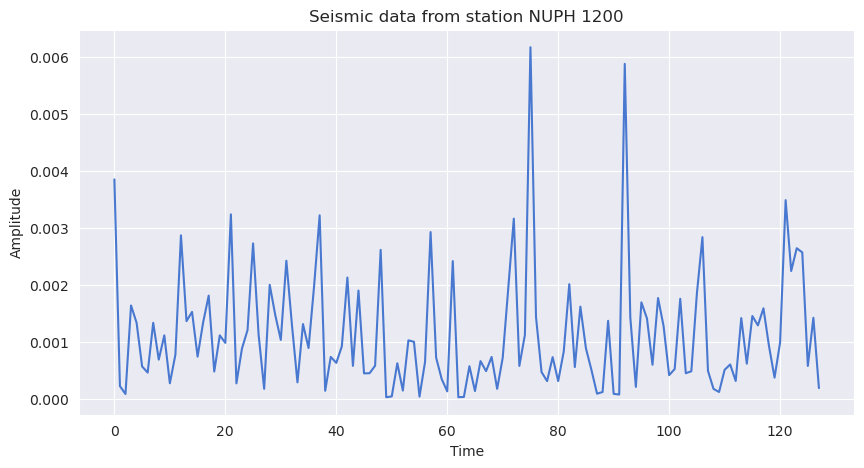

In [185]:
import matplotlib.pyplot as plt
import numpy as np

data_file = np.load('Input.npy')

# Specify the index of the row you want to plot (for example, row 0)
row_index = 1200 
column_index = 20  # Choose the specific column

plt.figure(figsize=(10, 5))
plt.plot(data_file[row_index, column_index])  # Plot the data at the specified row and column
plt.title(f'Seismic data from station NUPH {row_index}')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

In [186]:
# check the data in Input.npy and see if there are any negative values
print(f'Minimum value in data_file: {data_file.min()}')
print(f'Maximum value in data_file: {data_file.max()}')

Minimum value in data_file: 0.0
Maximum value in data_file: 11.04010009765625


# Autoencoder architecture construction

Import the dependencies first: `torch`, `torchinfo`


In [187]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchinfo import summary

# Set the seed for reproducibility
sd = 46
torch.manual_seed(sd)

# Function to calculate "same" padding for strided convolutions
def calculate_same_padding(kernel_size, stride):
    return ((stride - 1) + (kernel_size - 1)) // 2

# Define the autoencoder model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder layers with manually calculated "same" padding
        self.conv1 = nn.Conv2d(1, 8, kernel_size=(7, 5), stride=2, padding=(calculate_same_padding(7, 2), calculate_same_padding(5, 2)))
        self.conv2 = nn.Conv2d(8, 16, kernel_size=(5, 3), stride=2, padding=(calculate_same_padding(5, 2), calculate_same_padding(3, 2)))
        self.conv3 = nn.Conv2d(16, 32, kernel_size=(5, 3), stride=2, padding=(calculate_same_padding(5, 2), calculate_same_padding(3, 2)))
        self.conv4 = nn.Conv2d(32, 64, kernel_size=(5, 3), stride=2, padding=(calculate_same_padding(5, 2), calculate_same_padding(3, 2)))

        # Fully connected layers
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 6 * 8, 24)  # Adjusted based on conv output
        self.fc2 = nn.Linear(24, 3072)

        # Decoder layers
        self.fc3 = nn.Linear(3072, 64 * 6 * 8)  # Adjust based on the shape before flattening
        self.conv_transpose1 = nn.ConvTranspose2d(64, 32, kernel_size=(5, 3), stride=2, padding=(2, 1), output_padding=(1, 1))  # Adjust output_padding
        self.conv_transpose2 = nn.ConvTranspose2d(32, 16, kernel_size=(5, 3), stride=2, padding=(2, 1), output_padding=(1, 1))
        self.conv_transpose3 = nn.ConvTranspose2d(16, 8, kernel_size=(5, 3), stride=2, padding=(2, 1), output_padding=(1, 1))
        self.conv_transpose4 = nn.ConvTranspose2d(8, 1, kernel_size=(7, 5), stride=2, padding=(3, 2), output_padding=(1, 1))  # Adjust padding/output_padding

    def forward(self, x):
        # Encoder
        x = F.elu(self.conv1(x))
        x = F.elu(self.conv2(x))
        x = F.elu(self.conv3(x))
        x = F.elu(self.conv4(x))

        # Save shape for later use in decoder
        shape_before_flattening = x.shape

        # Fully connected layers
        x = self.flatten(x)
        encoded = F.elu(self.fc1(x))
        x = F.elu(self.fc2(encoded))

        # Decoder
        x = F.elu(self.fc3(x))
        x = x.view(-1, 64, 6, 8)  # Reshape to the shape before flattening
        x = F.elu(self.conv_transpose1(x))
        x = F.elu(self.conv_transpose2(x))
        x = F.elu(self.conv_transpose3(x))
        decoded = self.conv_transpose4(x)  # No activation for output layer

        return decoded, encoded


# Create model instance
autoencoder = Autoencoder()

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the device
autoencoder.to(device)

# Ensure that the input data is on the same device (for example, random input)
dummy_input = torch.randn(1, 1, 96, 128).to(device)  # Simulate a batch of size 1

# Now use torchinfo for the summary
summary(autoencoder, input_size=(1, 1, 96, 128))

Layer (type:depth-idx)                   Output Shape              Param #
Autoencoder                              [1, 1, 96, 128]           --
├─Conv2d: 1-1                            [1, 8, 48, 64]            288
├─Conv2d: 1-2                            [1, 16, 24, 32]           1,936
├─Conv2d: 1-3                            [1, 32, 12, 16]           7,712
├─Conv2d: 1-4                            [1, 64, 6, 8]             30,784
├─Flatten: 1-5                           [1, 3072]                 --
├─Linear: 1-6                            [1, 24]                   73,752
├─Linear: 1-7                            [1, 3072]                 76,800
├─Linear: 1-8                            [1, 3072]                 9,440,256
├─ConvTranspose2d: 1-9                   [1, 32, 12, 16]           30,752
├─ConvTranspose2d: 1-10                  [1, 16, 24, 32]           7,696
├─ConvTranspose2d: 1-11                  [1, 8, 48, 64]            1,928
├─ConvTranspose2d: 1-12                  [1, 1, 9

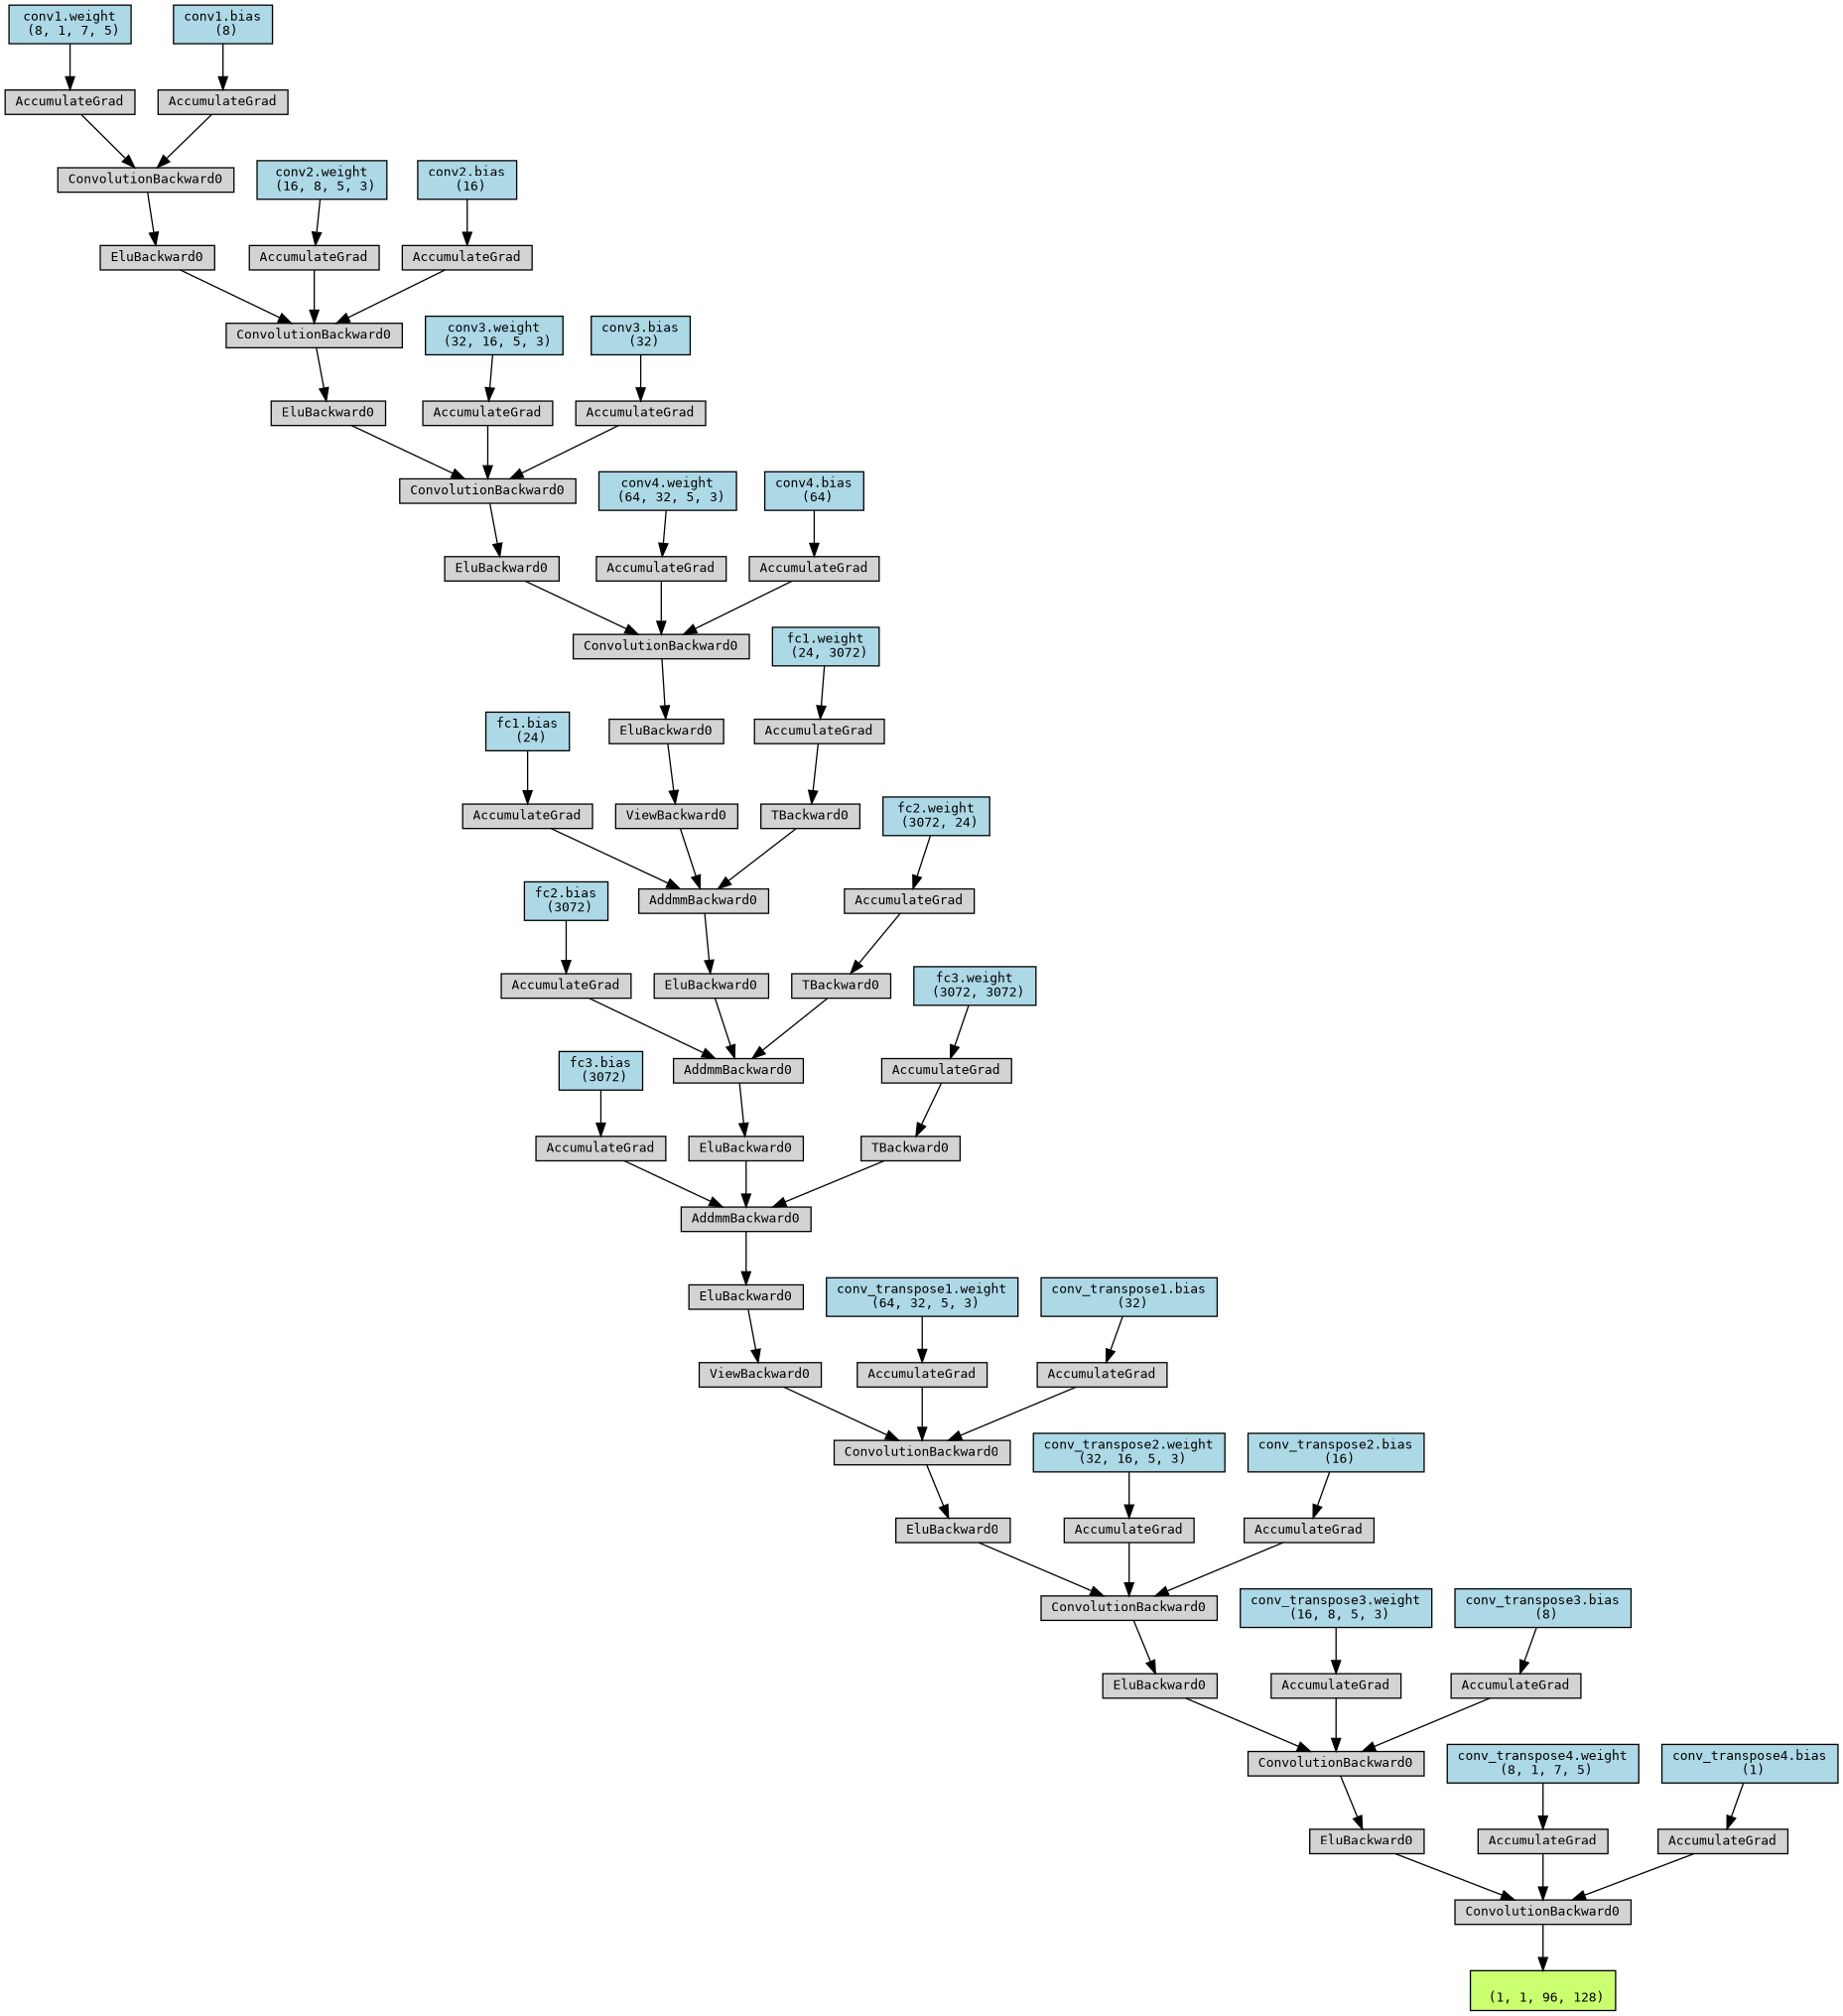

In [188]:
# use torchinfo to visualize the autoencoder
from torchinfo import summary
from torchviz import make_dot
from IPython.display import display, Image

# Print the summary of the model
summary(autoencoder, input_size=(1, 1, 96, 128))

# Create a dummy input tensor
dummy_input = torch.randn(1, 1, 96, 128).to(device)

# Generate the model visualization
try:
    model_vis = make_dot(autoencoder(dummy_input)[0], params=dict(autoencoder.named_parameters()))
    model_vis.format = 'png'
    model_vis.render('autoencoder')
    display(Image(filename='autoencoder.png', width=1000, height=600))
except Exception as e:
    print(f"Error creating or displaying model plot: {e}")

The `Linear: 1-8 layer` is a fully connected linear layer that flattens the output into 3072 * 3072 parameters. The original keras model reshaped this layer and had 0 parameters.

# Initial training phase: Pretraining the autoencoder

In [189]:
start_time = time.time()

import torch
import torch.optim as optim
import torch.nn as nn
from torch.optim.lr_scheduler import ExponentialLR
import pandas as pd

# Define constants
NUM_OF_EPOCHS = 500
initial_lr = 0.001
decay_steps = 1000
decay_rate = 0.5
patience = 30

# Initialize model, optimizer, and scheduler
model = Autoencoder().to(device)
criterion = nn.MSELoss()
#optimizer = optim.Adam(model.parameters(), lr=initial_lr)
optimizer = optim.Adam(model.parameters(), lr=initial_lr, weight_decay=1e-5)  #NEW
scheduler = ExponentialLR(optimizer, gamma=decay_rate**(1 / decay_steps))

# Setup CSV logger
csv_log = {'epoch': [], 'train_loss': [], 'val_loss': [], 'learning_rate': []}

# Early stopping parameters
best_val_loss = float('inf')
early_stop_counter = 0

# Training loop with early stopping and logging
for epoch in range(NUM_OF_EPOCHS):
    # Training phase
    model.train()
    train_loss = 0
    for data, _ in train_loader:
        
        data = data.unsqueeze(1)
        inputs = data.to(device)
        optimizer.zero_grad()
        outputs, _ = model(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    # Validation phase
    model.eval()
    val_loss = 0
    with torch.no_grad():
        #for data, _ in test_loader:
        for data, _ in val_loader:  #NEW
            
            data = data.unsqueeze(1)
            inputs = data.to(device)
            outputs, _ = model(inputs)
            loss = criterion(outputs, inputs)
            val_loss += loss.item()

    # Average losses
    train_loss /= len(train_loader)
    #val_loss /= len(test_loader)
    val_loss /= len(val_loader)  #NEW

    # Log values
    current_lr = scheduler.get_last_lr()[0]
    csv_log['epoch'].append(epoch + 1)
    csv_log['train_loss'].append(train_loss)
    csv_log['val_loss'].append(val_loss)
    csv_log['learning_rate'].append(current_lr)

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    # Print progress
    print(f"Epoch {epoch+1}/{NUM_OF_EPOCHS}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, LR: {current_lr:.6f}")

    # Step the learning rate scheduler
    scheduler.step()

# Save the CSV log
pd.DataFrame(csv_log).to_csv('pretrain_log.csv', index=False)

end_time = time.time()
print(f"Pretraining took {end_time - start_time:.2f} seconds")


Epoch 1/500, Train Loss: 0.2040, Val Loss: 0.1003, LR: 0.001000
Epoch 2/500, Train Loss: 0.0819, Val Loss: 0.0808, LR: 0.000999
Epoch 3/500, Train Loss: 0.0721, Val Loss: 0.0744, LR: 0.000999
Epoch 4/500, Train Loss: 0.0672, Val Loss: 0.0710, LR: 0.000998
Epoch 5/500, Train Loss: 0.0662, Val Loss: 0.0727, LR: 0.000997
Epoch 6/500, Train Loss: 0.0611, Val Loss: 0.0643, LR: 0.000997
Epoch 7/500, Train Loss: 0.0575, Val Loss: 0.0605, LR: 0.000996
Epoch 8/500, Train Loss: 0.0565, Val Loss: 0.0593, LR: 0.000995
Epoch 9/500, Train Loss: 0.0542, Val Loss: 0.0579, LR: 0.000994
Epoch 10/500, Train Loss: 0.0530, Val Loss: 0.0564, LR: 0.000994
Epoch 11/500, Train Loss: 0.0525, Val Loss: 0.0562, LR: 0.000993
Epoch 12/500, Train Loss: 0.0524, Val Loss: 0.0560, LR: 0.000992
Epoch 13/500, Train Loss: 0.0515, Val Loss: 0.0547, LR: 0.000992
Epoch 14/500, Train Loss: 0.0509, Val Loss: 0.0560, LR: 0.000991
Epoch 15/500, Train Loss: 0.0515, Val Loss: 0.0571, LR: 0.000990
Epoch 16/500, Train Loss: 0.0514, 

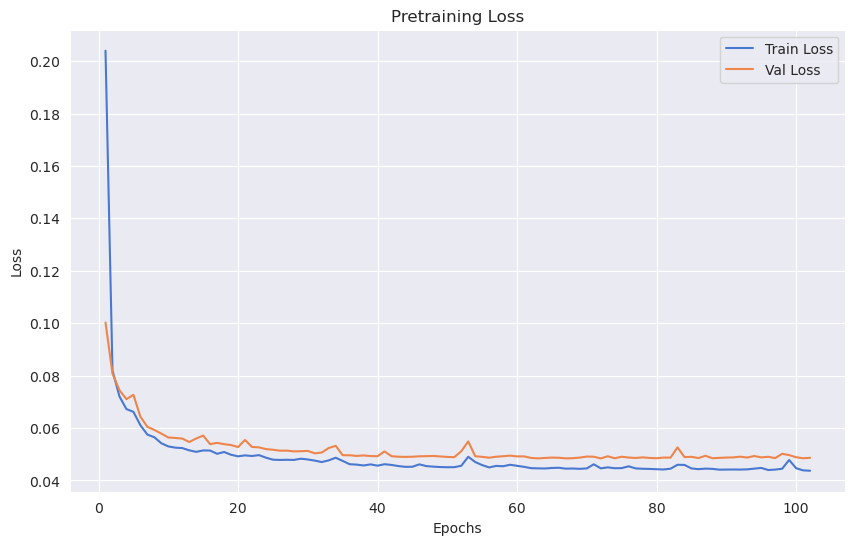

In [190]:
# plot training loss and validation loss

import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV log
pretrain_log = pd.read_csv('pretrain_log.csv')

# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(pretrain_log['epoch'], pretrain_log['train_loss'], label='Train Loss')
plt.plot(pretrain_log['epoch'], pretrain_log['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Pretraining Loss')
plt.legend()
plt.grid(True)
plt.show()


Test the model after training and validation

In [191]:
# Test the model after training
model.eval()
test_loss = 0.0
with torch.no_grad():
    for data, _ in test_loader:
        data = data.unsqueeze(1)
        inputs = data.to(device)
        outputs, _ = model(inputs)
        loss = criterion(outputs, inputs)
        test_loss += loss.item()

test_loss /= len(test_loader)
print(f"Test Loss: {test_loss:.4f}")

Test Loss: 0.0533


# Evaluate autoencoder reconstruction

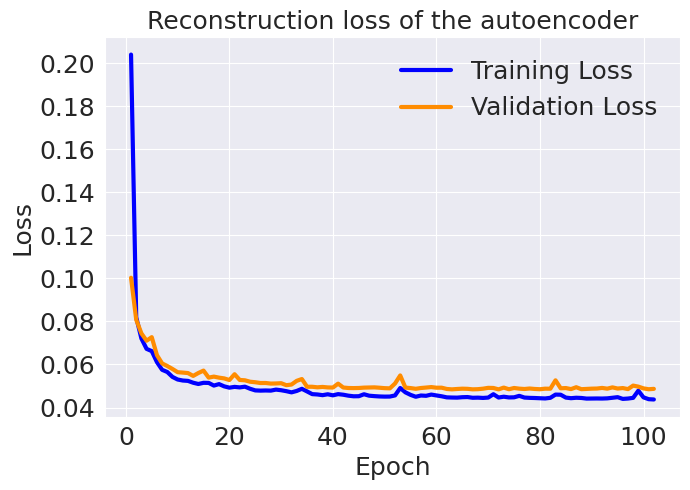

In [192]:
import pandas as pd
df = pd.read_csv('pretrain_log.csv')
fig= plt.figure(figsize=(7, 5))
plt.plot(df['epoch'],df['train_loss'], color='b',label='Training Loss', linewidth=3.0)
plt.plot(df['epoch'],df['val_loss'], color='darkorange',label='Validation Loss', linewidth=3.0)

plt.ylabel('Loss', fontsize= 18)
plt.xlabel('Epoch', fontsize= 18)
plt.title('Reconstruction loss of the autoencoder', fontsize= 18)
plt.yticks (fontsize= 18)
plt.xticks (fontsize= 18)

plt.legend(loc= 1, frameon= False, fontsize= 18)
plt.tight_layout()
plt.show ()
fig.savefig ( 'ReconstructionLoss.png', dpi= 100)

In [193]:
# Save the model's state_dict
torch.save(model.state_dict(), 'autoencoder-model.pth')

# Re-import or re-define the Autoencoder class
autoencoder = Autoencoder()  # Instantiate the model
autoencoder.load_state_dict(torch.load('autoencoder-model.pth'))  # Load the state_dict

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
autoencoder.to(device)

# Set the model to evaluation mode if you're testing or inferring
autoencoder.eval()


/tmp/ipykernel_4084/434218544.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  autoencoder.load_state_dict(torch.load('autoencoder-model.pth'))  # Load the state_dict


Autoencoder(
  (conv1): Conv2d(1, 8, kernel_size=(7, 5), stride=(2, 2), padding=(3, 2))
  (conv2): Conv2d(8, 16, kernel_size=(5, 3), stride=(2, 2), padding=(2, 1))
  (conv3): Conv2d(16, 32, kernel_size=(5, 3), stride=(2, 2), padding=(2, 1))
  (conv4): Conv2d(32, 64, kernel_size=(5, 3), stride=(2, 2), padding=(2, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=3072, out_features=24, bias=True)
  (fc2): Linear(in_features=24, out_features=3072, bias=True)
  (fc3): Linear(in_features=3072, out_features=3072, bias=True)
  (conv_transpose1): ConvTranspose2d(64, 32, kernel_size=(5, 3), stride=(2, 2), padding=(2, 1), output_padding=(1, 1))
  (conv_transpose2): ConvTranspose2d(32, 16, kernel_size=(5, 3), stride=(2, 2), padding=(2, 1), output_padding=(1, 1))
  (conv_transpose3): ConvTranspose2d(16, 8, kernel_size=(5, 3), stride=(2, 2), padding=(2, 1), output_padding=(1, 1))
  (conv_transpose4): ConvTranspose2d(8, 1, kernel_size=(7, 5), stride=(2, 2), padding=(3, 2)

In [194]:
data_tensor = torch.tensor(data_file)  # Convert to PyTorch tensor
data_tensor = data_tensor.unsqueeze(1)  # Adds a dimension at position 1

data_tensor.shape

torch.Size([2328, 1, 96, 128])

### Autoencoder input-output visualization

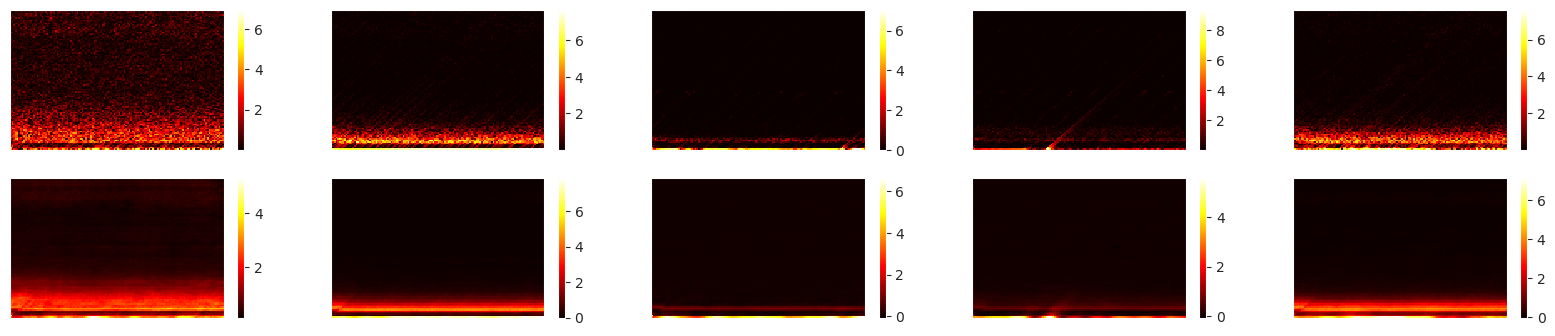

In [195]:
decoded_imgs, _ = autoencoder(data_tensor.float().to(device))

import librosa
import librosa.display

s = 300
e= 305
n = e-s

plt.figure(figsize=(20, 4))
for i in range(s,e):
    
    # Display original
    ax = plt.subplot(2, n, i-s + 1)
    librosa.display.specshow(data_file[i,:,:], alpha=None, cmap='hot', antialiased=True)
    plt.colorbar ()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i-s + 1 + n)
    librosa.display.specshow(decoded_imgs.cpu().detach().numpy()[i,0, :,:], alpha=None, cmap='hot', antialiased=True)
    plt.colorbar ()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

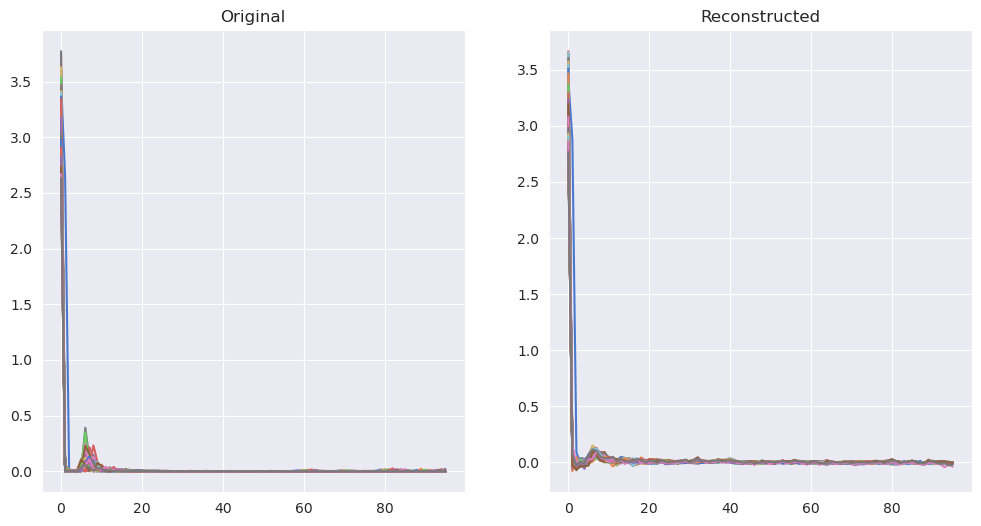

In [196]:
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    data, _ = next(iter(test_loader))
    data = data.unsqueeze(1).to(device)
    outputs, _ = model(data)
    data, outputs = data.cpu().numpy(), outputs.cpu().numpy()

# Plot original vs reconstructed for a single example
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(data[0].squeeze())
plt.title("Original")
plt.subplot(1, 2, 2)
plt.plot(outputs[0].squeeze())
plt.title("Reconstructed")
plt.show()


## Kmeans clustering based on extracted features from the autoencoder

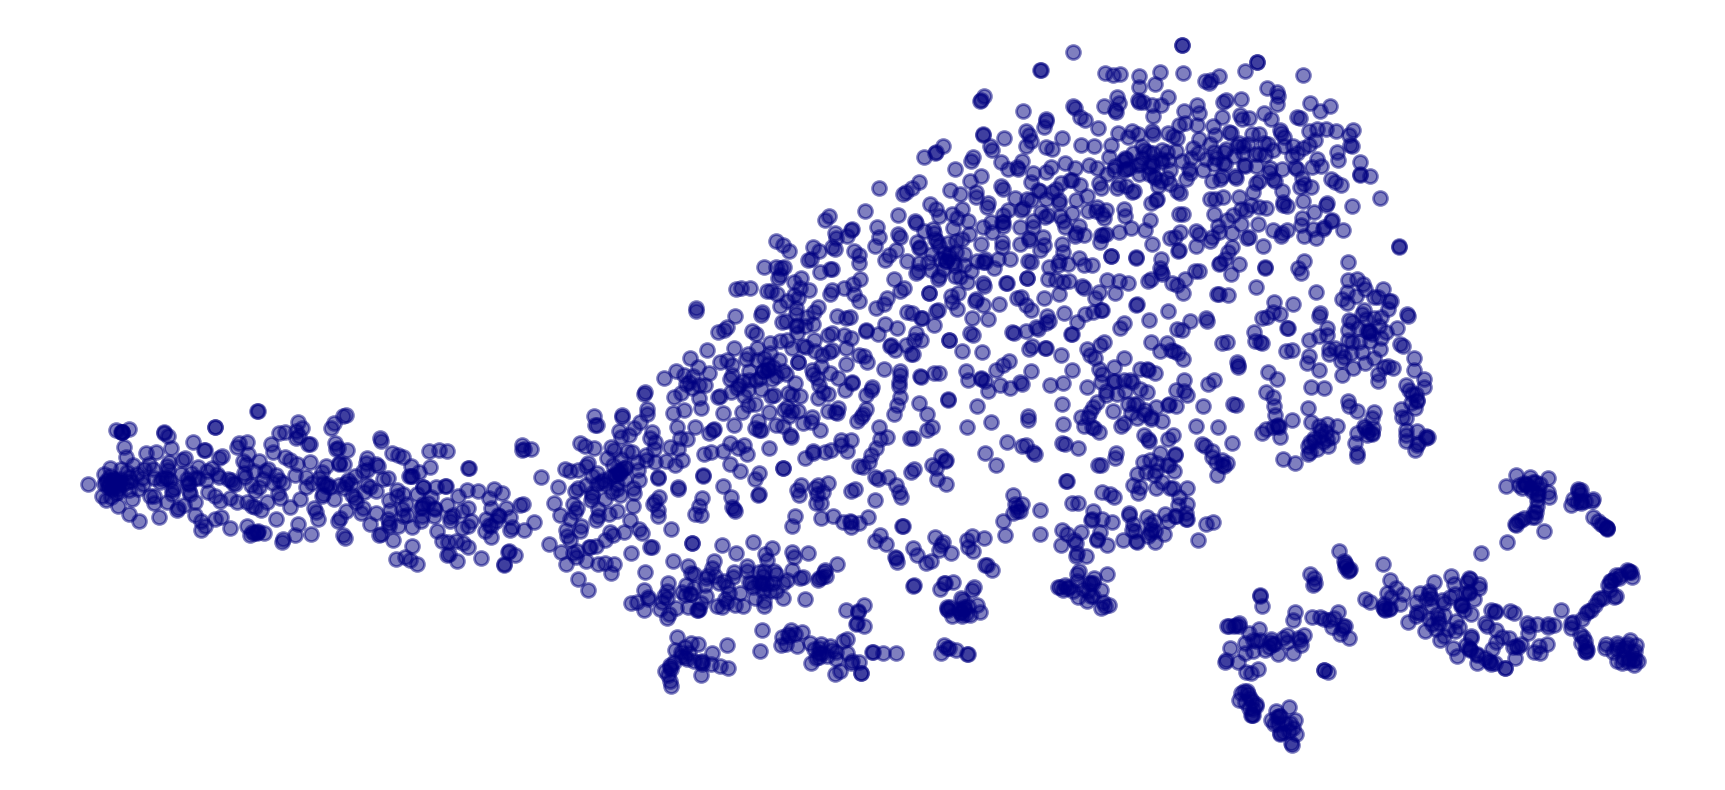

(<Figure size 2200x1000 with 1 Axes>, <Axes: >)

In [197]:
decoded_imgs, encoded_imgs = autoencoder(data_tensor.float().to(device))

kmeans = KMeans(n_clusters=1, random_state=46, n_init=20).fit(encoded_imgs.cpu().detach().numpy())
y = kmeans.predict(encoded_imgs.cpu().detach().numpy())

def plotter(S, y):
    '''
    function to visualize the outputs of t-SNE
    '''
    
    lw = 2
    # create a scatter plot.
    f = plt.figure(figsize=(22, 10))
    ax = f.add_subplot(111)
    plt.scatter(S[y == 0, 0], S[y == 0, 1],color='navy', alpha=.5, lw=lw, s=100)
    ax.axis('off')
    ax.axis('tight') 
    plt.show()
    f.savefig ('Tnse-km-n1', dpi= 100,bbox_inches = "tight")

    return f, ax

enc = encoded_imgs.cpu().detach().numpy()

from sklearn.manifold import TSNE
redu = TSNE(random_state=123).fit_transform(enc)
plotter(redu, y) 


# Determining optimal number of clusters

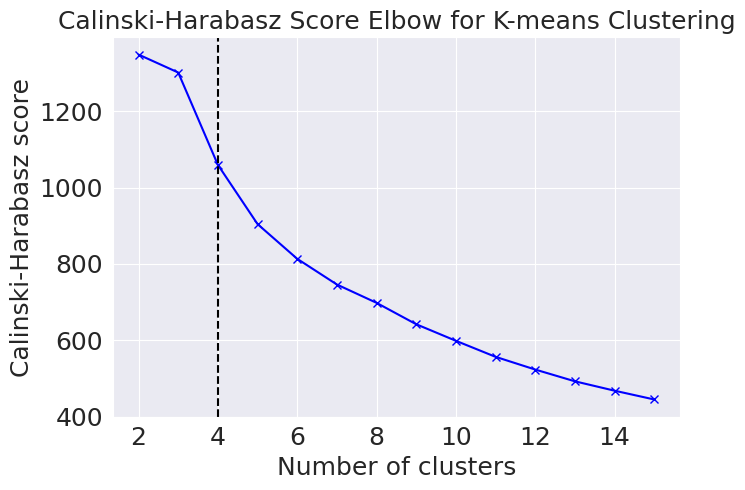

Elbow point: 3


In [198]:
from sklearn.metrics import calinski_harabasz_score
cal = []
K = range(2,16)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=20).fit(encoded_imgs.cpu().detach().numpy())
    labelskm = kmeans.predict(encoded_imgs.cpu().detach().numpy())
    cal.append(calinski_harabasz_score(encoded_imgs.cpu().detach().numpy(), labelskm))
fig= plt.figure(figsize=(7, 5))
plt.plot(K, cal, 'bx-')
plt.xlabel('Number of clusters',fontsize= 18)
plt.ylabel('Calinski-Harabasz score',fontsize= 18)
plt.title('Calinski-Harabasz Score Elbow for K-means Clustering',fontsize= 18)
plt.yticks (fontsize= 18)
plt.xticks (fontsize= 18)
plt.axvline(x=4, color='black', linestyle='--')  # change if this isn't the correct number for your work
plt.tight_layout()
plt.show()
fig.savefig ( 'Calinski score.png', dpi=100)

diff = np.diff(cal)
elbow_point = np.argmin(diff) + 2  # adding 2 because the cluster range K starts at 2
print(f'Elbow point: {elbow_point}')

# T-sne visualizations of seismic event clusters in feature domain after pretraining

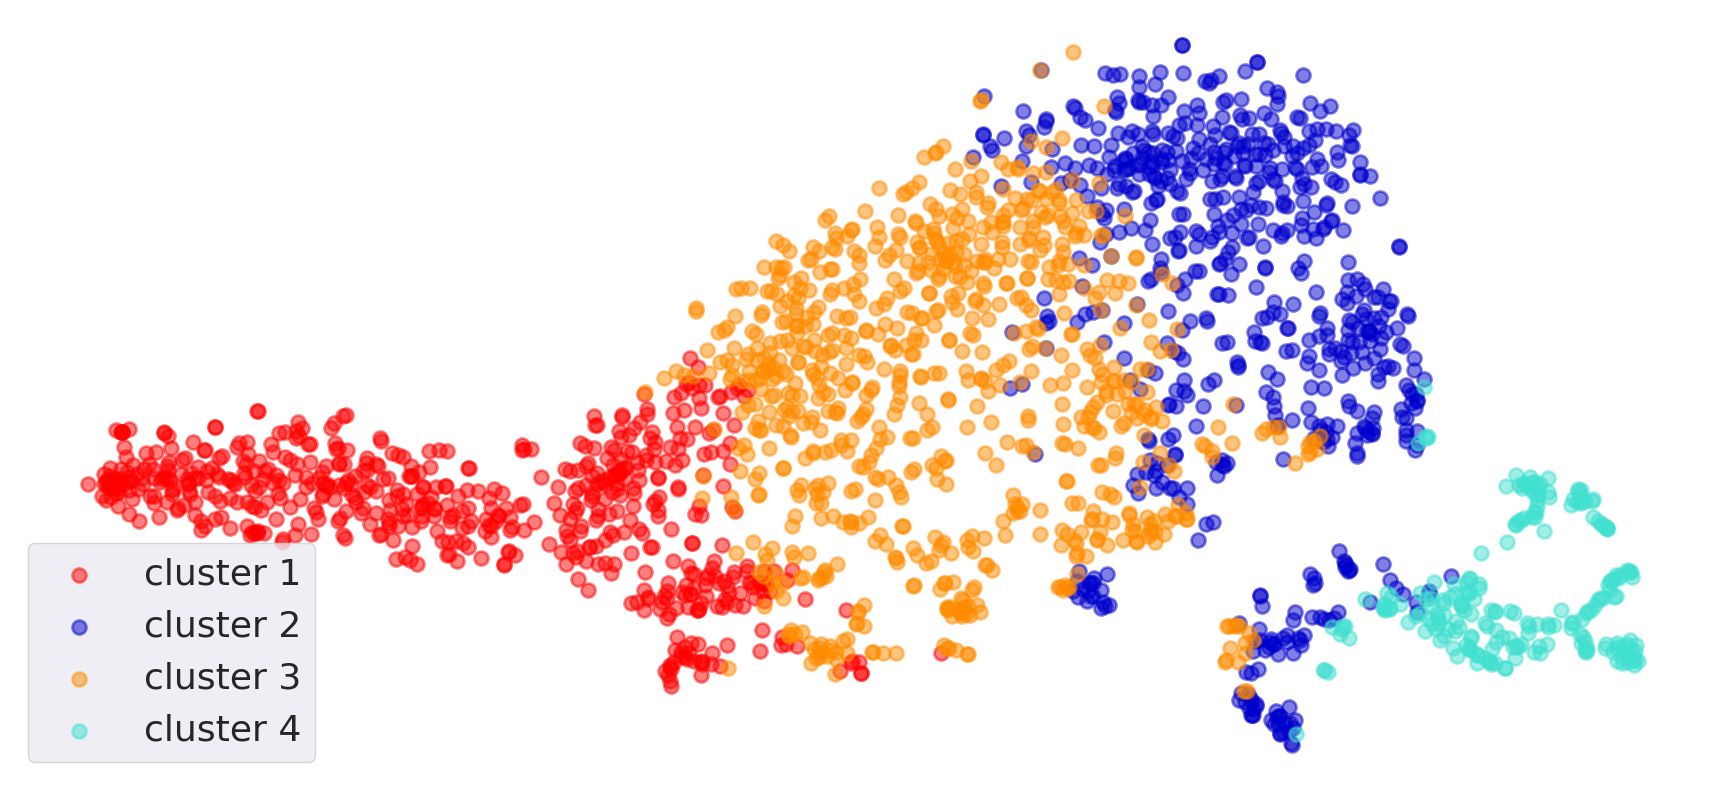

(<Figure size 2200x1000 with 1 Axes>, <Axes: >)

In [199]:
enc = encoded_imgs.cpu().detach().numpy()
kmeans = KMeans(n_clusters=4, random_state=46, n_init=20).fit(encoded_imgs.cpu().detach().numpy())
y = kmeans.predict(enc)

def plotter(S, y, target_names):
    '''
    function to visualize the outputs of t-SNE
    '''
    # choose a color palette with seaborn.
    colors = [ 'red', 'mediumblue','darkorange','turquoise','lime', 'turquoise', 'darkorange','lawngreen', 'red', 'saddlebrown']
    
    lw = 2
    # create a scatter plot.
    f = plt.figure(figsize=(22, 10))
    ax = f.add_subplot(111)
    for color, i, target_name in zip(colors, [3,0, 1,2], target_names):
        plt.scatter(S[y == i, 0], S[y == i, 1], color=color, alpha=.5, lw=lw, s=100, label=target_name)
    plt.legend(loc='lower left', shadow=False, scatterpoints=1, prop={'size': 26})
    ax.axis('off')
    ax.axis('tight') 
    plt.show()
    f.savefig ('Tnse-km-n4', dpi= 100,bbox_inches = "tight")

    return f, ax

enc = encoded_imgs.cpu().detach().numpy()
from sklearn.manifold import TSNE
redu = TSNE(random_state=123).fit_transform(enc)
target_names = ['cluster 1', 'cluster 2', 'cluster 3', 'cluster 4']
plotter(redu, y, target_names) 


# Loading the pre-trained model

In [200]:
data_tensor = torch.tensor(data_file)  # Convert to PyTorch tensor
data_tensor = data_tensor.unsqueeze(1).to(device)  # Adds a dimension at position 1


# Assuming autoencoder and data_file are already defined
autoencoder.eval()  # Set to evaluation mode

# Define a dictionary to store layer outputs
layer_outputs = {}

# Function to create hooks for capturing the outputs
def get_layer_output_hook(name):
    def hook(module, input, output):
        layer_outputs[name] = output
    return hook

# Register hooks on each layer you want to capture (starting from layer 1 as in your example)
for idx, layer in enumerate(list(autoencoder.children())[1:], start=1):
    layer.register_forward_hook(get_layer_output_hook(f'layer_{idx}'))

# Run a forward pass with `data_file` to capture the outputs
with torch.no_grad():  # Disable gradient computation
    data = torch.tensor(data_tensor, dtype=torch.float32)  # Convert data_file to tensor
    autoencoder(data)  # Run data through the model to capture intermediate outputs

# Display the outputs
for name, output in layer_outputs.items():
    print(f"{name} output shape: {output.shape}")


layer_1 output shape: torch.Size([2328, 16, 24, 32])
layer_2 output shape: torch.Size([2328, 32, 12, 16])
layer_3 output shape: torch.Size([2328, 64, 6, 8])
layer_4 output shape: torch.Size([2328, 3072])
layer_5 output shape: torch.Size([2328, 24])
layer_6 output shape: torch.Size([2328, 3072])
layer_7 output shape: torch.Size([2328, 3072])
layer_8 output shape: torch.Size([2328, 32, 12, 16])
layer_9 output shape: torch.Size([2328, 16, 24, 32])
layer_10 output shape: torch.Size([2328, 8, 48, 64])
layer_11 output shape: torch.Size([2328, 1, 96, 128])


/tmp/ipykernel_4084/174646368.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data_tensor, dtype=torch.float32)  # Convert data_file to tensor


# Integrating clustering layer into autoencoder bottleneck

In [201]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

# Set seed for reproducibility
seed = 46
torch.manual_seed(seed)
np.random.seed(seed)

# Initialize Xavier initializer (same as GlorotUniform in TensorFlow)
initializer = nn.init.xavier_uniform_
n_clusters = 4 # Set desired number of clusters


# Define the clustering layer in PyTorch
class ClusteringLayer(nn.Module):
    def __init__(self, n_clusters, input_dim, alpha=1.0):
        super(ClusteringLayer, self).__init__()
        self.n_clusters = n_clusters
        self.alpha = alpha
        
        # Initialize the cluster centers
        self.clusters = nn.Parameter(torch.Tensor(n_clusters, input_dim))
        # Define cluster centers as a trainable parameter
        
        initializer(self.clusters)  # Xavier initialization

    def forward(self, inputs):
        
        print(inputs.shape)
        self.clusters = self.clusters.to(inputs.device)
        # Compute the soft assignment q
        q = 1.0 / (1.0 + (torch.sum((inputs.unsqueeze(1) - self.clusters) ** 2, dim=2) / self.alpha))
        q = q ** ((self.alpha + 1.0) / 2.0)
        q = q / torch.sum(q, dim=1, keepdim=True)  # Normalize to get probabilities per cluster
        return q

# Define the full model with the clustering layer on top of the autoencoder
class ClusteredAutoencoder(nn.Module):
    def __init__(self, autoencoder, n_clusters):
        super(ClusteredAutoencoder, self).__init__()
        self.autoencoder = autoencoder
        # Clustering layer connected to the output of the encoder
        self.clustering_layer = ClusteringLayer(n_clusters=n_clusters, input_dim=24)  # Match to `encoded` dimension

    def forward(self, x):
        decoded, encoded = self.autoencoder(x)
        q = self.clustering_layer(encoded)  # Cluster assignments
        return decoded, q  # Return both decoded output and cluster assignments

# Instantiate the models
n_clusters = 4  # Set desired number of clusters
model = ClusteredAutoencoder(autoencoder, n_clusters=n_clusters)

# Define the KL-divergence loss function
def kld_loss(q, p):
    return F.kl_div(q.log(), p, reduction='batchmean')

# Example optimizer setup
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Training loop placeholder
def train(model, data_loader, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        for inputs, _ in data_loader:
            decoded, q = model(inputs)
            # Target distribution p, here using a sample softmax normalization of q as a placeholder
            p = (q ** 2) / torch.sum(q, dim=0)
            p = p / torch.sum(p, dim=1, keepdim=True)
            
            # Calculate the losses
            reconstruction_loss = F.mse_loss(decoded, inputs)   # Measures the element-wise mean squared error
            clustering_loss = kld_loss(q, p)        # Compute the KL Divergence loss.
            total_loss = 0.1 * clustering_loss + reconstruction_loss
            
            # Backward and optimize
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss.item():.4f}')

# Visualize the model (can be printed or logged)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the device
model.to(device)

# Ensure that the input data is on the same device (for example, random input)
dummy_input = torch.randn(1, 1, 96, 128).to(device)  # Simulate a batch of size 1

# Now use torchinfo for the summary
summary(model, input_size=(1, 1, 96, 128))

torch.Size([1, 24])


Layer (type:depth-idx)                   Output Shape              Param #
ClusteredAutoencoder                     [1, 1, 96, 128]           --
├─Autoencoder: 1-1                       [1, 1, 96, 128]           --
│    └─Conv2d: 2-1                       [1, 8, 48, 64]            288
│    └─Conv2d: 2-2                       [1, 16, 24, 32]           1,936
│    └─Conv2d: 2-3                       [1, 32, 12, 16]           7,712
│    └─Conv2d: 2-4                       [1, 64, 6, 8]             30,784
│    └─Flatten: 2-5                      [1, 3072]                 --
│    └─Linear: 2-6                       [1, 24]                   73,752
│    └─Linear: 2-7                       [1, 3072]                 76,800
│    └─Linear: 2-8                       [1, 3072]                 9,440,256
│    └─ConvTranspose2d: 2-9              [1, 32, 12, 16]           30,752
│    └─ConvTranspose2d: 2-10             [1, 16, 24, 32]           7,696
│    └─ConvTranspose2d: 2-11             [1, 8, 48, 

In [202]:
from sklearn.cluster import KMeans
import torch


# Assuming autoencoder and data_file are already defined
data_tensor = torch.tensor(data_file)  # Convert to PyTorch tensor
data_tensor = data_tensor.unsqueeze(1).to(device)  # Adds a dimension at position 1

autoencoder.eval()  # Set to evaluation mode

# Define a dictionary to store layer outputs
layer_outputs = {}

# Function to create hooks for capturing the outputs
def get_layer_output_hook(name):
    def hook(module, input, output):
        layer_outputs[name] = output
    return hook

# Register hooks on each layer you want to capture (starting from layer 1 as in your example)
for idx, layer in enumerate(list(autoencoder.children())[1:], start=1):
    layer.register_forward_hook(get_layer_output_hook(f'layer_{idx}'))

# Run a forward pass with `data_file` to capture the outputs
with torch.no_grad():  # Disable gradient computation
    data = data_tensor.float()  # Ensure data is in float32 format
    autoencoder(data)  # Run data through the model to capture intermediate outputs

# Display the outputs
for name, output in layer_outputs.items():
    print(f"{name} output shape: {output.shape}")
    
    

n_clusters = 4  # Define the number of clusters

# Step 1: Perform KMeans on the encoded output to initialize cluster centers
kmeans = KMeans(n_clusters=n_clusters, random_state=46, n_init=20)
encoded_output = layer_outputs['layer_5'].cpu().detach().numpy()  # Assuming this is the encoded output
y_pred = kmeans.fit_predict(encoded_output)
y_pred_last = np.copy(y_pred)

# Step 2: Set the KMeans cluster centers as initial weights in the clustering layer
cluster_centers = torch.tensor(kmeans.cluster_centers_, dtype=torch.float32, device = device)

# Assuming model.clustering_layer is the clustering layer in the PyTorch model
model.clustering_layer.clusters.data = cluster_centers  # Directly assign cluster centers

# Verify the initialization
print("Number of clusters in KMeans model:", kmeans.n_clusters)
print("Number of clusters in clustering layer:", model.clustering_layer.n_clusters)
print("Assigned KMeans cluster centers as initial weights in the clustering layer.")


layer_1 output shape: torch.Size([2328, 16, 24, 32])
layer_2 output shape: torch.Size([2328, 32, 12, 16])
layer_3 output shape: torch.Size([2328, 64, 6, 8])
layer_4 output shape: torch.Size([2328, 3072])
layer_5 output shape: torch.Size([2328, 24])
layer_6 output shape: torch.Size([2328, 3072])
layer_7 output shape: torch.Size([2328, 3072])
layer_8 output shape: torch.Size([2328, 32, 12, 16])
layer_9 output shape: torch.Size([2328, 16, 24, 32])
layer_10 output shape: torch.Size([2328, 8, 48, 64])
layer_11 output shape: torch.Size([2328, 1, 96, 128])
Number of clusters in KMeans model: 4
Number of clusters in clustering layer: 4
Assigned KMeans cluster centers as initial weights in the clustering layer.


In [203]:
model

ClusteredAutoencoder(
  (autoencoder): Autoencoder(
    (conv1): Conv2d(1, 8, kernel_size=(7, 5), stride=(2, 2), padding=(3, 2))
    (conv2): Conv2d(8, 16, kernel_size=(5, 3), stride=(2, 2), padding=(2, 1))
    (conv3): Conv2d(16, 32, kernel_size=(5, 3), stride=(2, 2), padding=(2, 1))
    (conv4): Conv2d(32, 64, kernel_size=(5, 3), stride=(2, 2), padding=(2, 1))
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (fc1): Linear(in_features=3072, out_features=24, bias=True)
    (fc2): Linear(in_features=24, out_features=3072, bias=True)
    (fc3): Linear(in_features=3072, out_features=3072, bias=True)
    (conv_transpose1): ConvTranspose2d(64, 32, kernel_size=(5, 3), stride=(2, 2), padding=(2, 1), output_padding=(1, 1))
    (conv_transpose2): ConvTranspose2d(32, 16, kernel_size=(5, 3), stride=(2, 2), padding=(2, 1), output_padding=(1, 1))
    (conv_transpose3): ConvTranspose2d(16, 8, kernel_size=(5, 3), stride=(2, 2), padding=(2, 1), output_padding=(1, 1))
    (conv_transpose4): ConvTran

torch.Size([2328, 24])


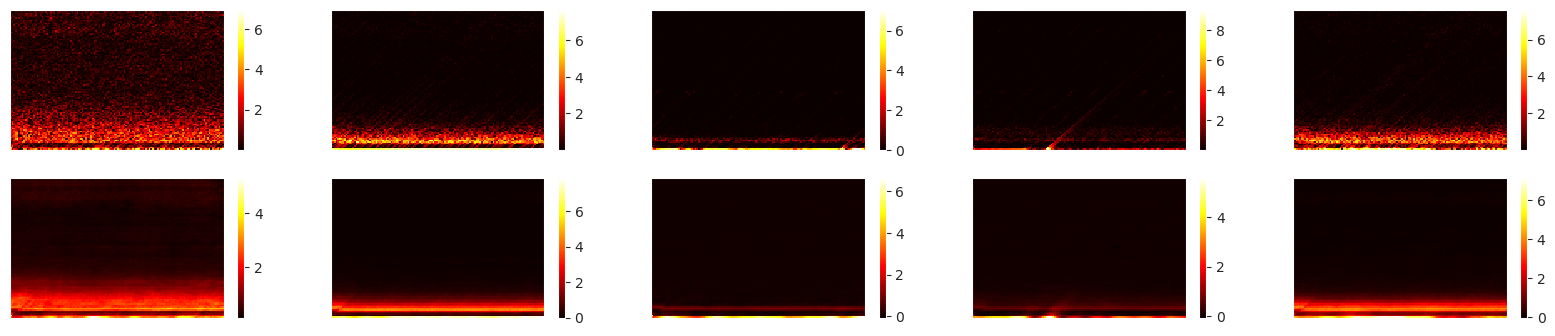

In [204]:
decoded_imgs  = model(data_tensor.float().to(device))[0]



import librosa
import librosa.display

s = 300
e= 305
n = e-s

plt.figure(figsize=(20, 4))
for i in range(s,e):
    
    # Display original
    ax = plt.subplot(2, n, i-s + 1)
    librosa.display.specshow(data_file[i,:,:], alpha=None, cmap='hot', antialiased=True)
    plt.colorbar ()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i-s + 1 + n)
    librosa.display.specshow(decoded_imgs.cpu().detach().numpy()[i,0, :,:], alpha=None, cmap='hot', antialiased=True)
    plt.colorbar ()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Finetuning pre-trained model parameters

In [205]:
import torch
import numpy as np

model.eval()

# Parameters for fine-tuning
batch_size = 32
tol = 0.0001  # tolerance threshold for early stopping
loss_value = 0
index = 0
maxiter = 300
update_interval = 200
index_array = np.arange(data_file.shape[0])
y_pred_last = np.zeros(data_file.shape[0])

data_tensor = torch.tensor(data_file, dtype=torch.float32)
data_tensor = data_tensor.unsqueeze(1).to(device)  # Adds a dimension at position 1

# Define the target distribution function
def target_distribution(q):
    weight = q ** 2 / np.sum(q, axis=0)
    return (weight.T / np.sum(weight, axis=1)).T

# Fine-tuning loop
for ite in range(maxiter):
    print(f"Iteration: {ite}")
    
    # Update clustering target distribution periodically
    if ite % update_interval == 0:
        print("Updating target distribution")
        
        # Forward pass to get cluster assignments
        with torch.no_grad():
            _, q = model(data_tensor)
            q = q.cpu().numpy()  # Convert to numpy for further processing
        
        # Update the target distribution `p`
        p = target_distribution(q)
        y_pred = q.argmax(1)  # Get cluster assignments
        
        # Print loss and clustering information
        print(f"Iter {ite}: ; loss={round(loss_value, 5)}")

        # Check convergence criterion
        delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
        y_pred_last = np.copy(y_pred)
        
        if ite > 0 and delta_label < tol:
            print(f"Convergence achieved: delta_label {delta_label} < tol {tol}")
            break
    
    # Mini-batch training
    start_idx = index * batch_size
    end_idx = min((index + 1) * batch_size, data_file.shape[0])
    idx = index_array[start_idx:end_idx]
    
    batch_data = data_tensor[idx]
    batch_p = torch.tensor(p[idx], dtype=torch.float32, device = device)

    # Zero gradients, forward pass, compute loss, backward pass, and update
    optimizer.zero_grad()
    decoded, q_batch = model(batch_data)
    clustering_loss = F.kl_div(q_batch.log(), batch_p, reduction="batchmean")
    reconstruction_loss = F.mse_loss(decoded, batch_data)
    total_loss = clustering_loss * 0.1 + reconstruction_loss
    total_loss.backward()
    optimizer.step()

    # Update loss and index for next iteration
    loss_value = total_loss.item()
    index = (index + 1) % (data_file.shape[0] // batch_size)


Iteration: 0
Updating target distribution
torch.Size([2328, 24])
Iter 0: ; loss=0
torch.Size([32, 24])
Iteration: 1
torch.Size([32, 24])
Iteration: 2
torch.Size([32, 24])
Iteration: 3
torch.Size([32, 24])
Iteration: 4
torch.Size([32, 24])
Iteration: 5
torch.Size([32, 24])
Iteration: 6
torch.Size([32, 24])
Iteration: 7
torch.Size([32, 24])
Iteration: 8
torch.Size([32, 24])
Iteration: 9
torch.Size([32, 24])
Iteration: 10
torch.Size([32, 24])
Iteration: 11
torch.Size([32, 24])
Iteration: 12
torch.Size([32, 24])
Iteration: 13
torch.Size([32, 24])
Iteration: 14
torch.Size([32, 24])
Iteration: 15
torch.Size([32, 24])
Iteration: 16
torch.Size([32, 24])
Iteration: 17
torch.Size([32, 24])
Iteration: 18
torch.Size([32, 24])
Iteration: 19
torch.Size([32, 24])
Iteration: 20
torch.Size([32, 24])
Iteration: 21
torch.Size([32, 24])
Iteration: 22
torch.Size([32, 24])
Iteration: 23
torch.Size([32, 24])
Iteration: 24
torch.Size([32, 24])
Iteration: 25
torch.Size([32, 24])
Iteration: 26
torch.Size([32, 2

# T-sne visualizations of seismic event clusters in feature domain after finetuning

Number of NaNs in encoded output: 0
amount of encoded output: (2328, 24)
amount of NOT NaNs in encoded output: 55872


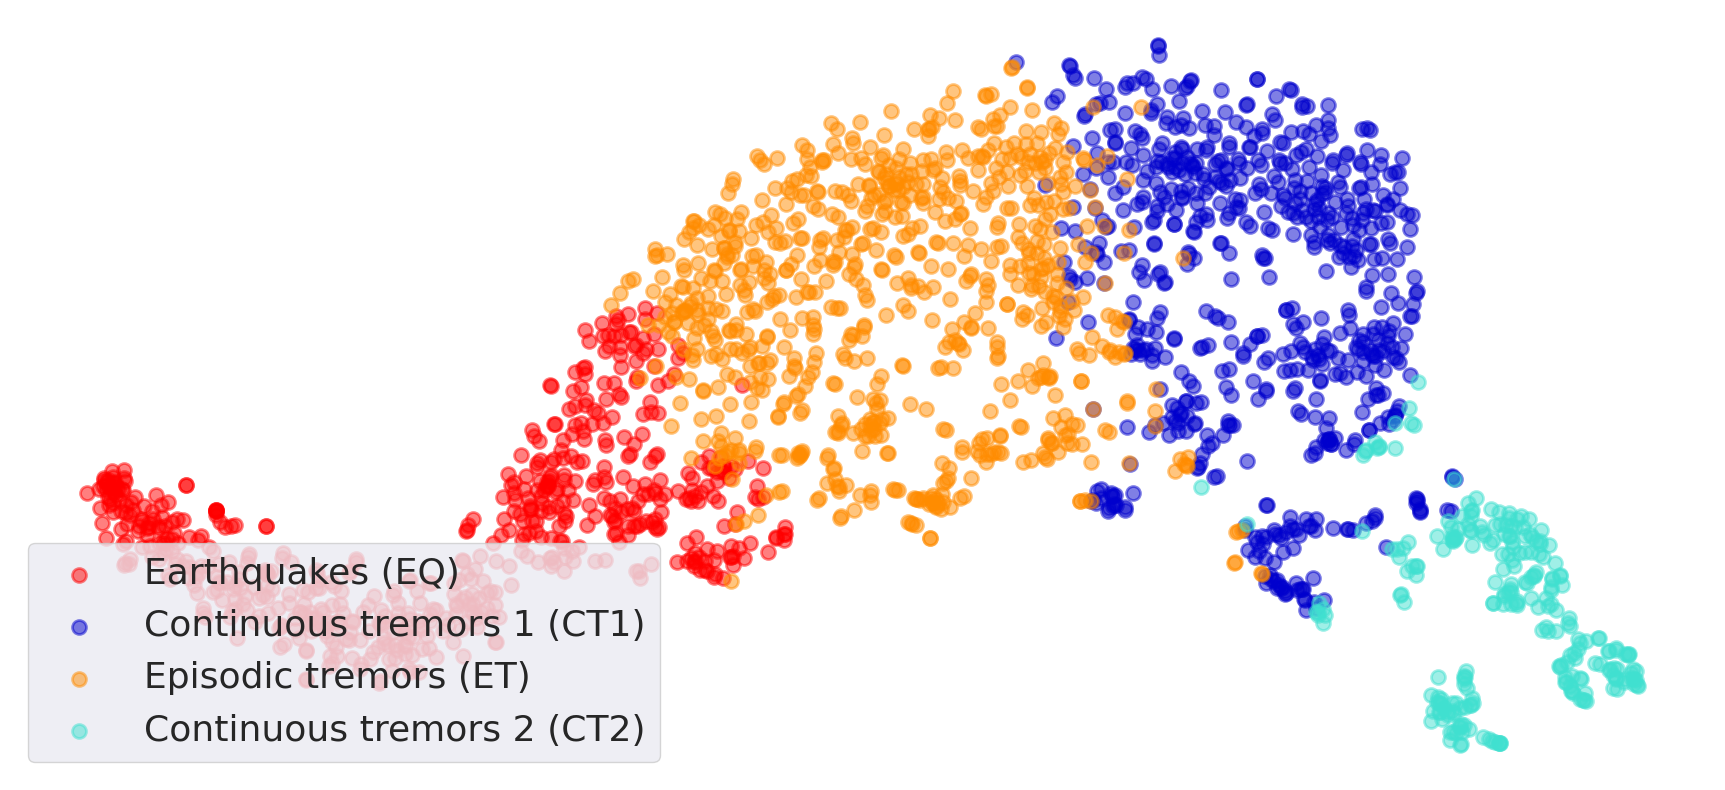

(<Figure size 2200x1000 with 1 Axes>, <Axes: >)

In [206]:
autoencoder.eval()  # Set to evaluation mode

# Define a dictionary to store layer outputs
layer_outputs = {}

# Function to create hooks for capturing the outputs
def get_layer_output_hook(name):
    def hook(module, input, output):
        layer_outputs[name] = output
    return hook

# Register hooks on each layer you want to capture (starting from layer 1 as in your example)
for idx, layer in enumerate(list(autoencoder.children())[1:], start=1):
    layer.register_forward_hook(get_layer_output_hook(f'layer_{idx}'))

# Run a forward pass with `data_file` to capture the outputs
with torch.no_grad():  # Disable gradient computation
    data = data_tensor.float()  # Ensure data is in float32 format
    autoencoder(data)  # Run data through the model to capture intermediate outputs

y=y_pred

def plotter(S, y, target_names):
    '''
    function to visualize the outputs of t-SNE
    '''
    # choose a color palette with seaborn.
    colors = ['red', 'mediumblue','darkorange','turquoise', 'lawngreen', 'red', 'saddlebrown']
    
    lw = 2
    # create a scatter plot.
    f = plt.figure(figsize=(22, 10))
    ax = f.add_subplot(111)
    for color, i, target_name in zip(colors, [3,0, 1,2], target_names):
        plt.scatter(S[y == i, 0], S[y == i, 1], color=color, alpha=0.5, lw=lw, s=100, label=target_name)
    plt.legend(loc='lower left', shadow=False, scatterpoints=1, prop={'size': 26})
    ax.axis('off')
    ax.axis('tight') 
    plt.show()
    f.savefig ('Tsne-km-n4-ft.png', dpi= 100,bbox_inches = "tight")
    
    return f, ax


enc = layer_outputs['layer_5'].cpu().detach().numpy()

print(f'Number of NaNs in encoded output: {np.isnan(enc).sum()}')
print(f'amount of encoded output: {enc.shape}')
print(f'amount of NOT NaNs in encoded output: {np.count_nonzero(~np.isnan(enc))}')

from sklearn.manifold import TSNE
redu = TSNE(random_state=123).fit_transform(enc)
target_names = [ 'Earthquakes (EQ)','Continuous tremors 1 (CT1)', 'Episodic tremors (ET)', 'Continuous tremors 2 (CT2)' ]
plotter(redu, y, target_names) 


In [207]:
### Save the labels
np.savetxt('km-n4-ft.txt', y, fmt='%i', delimiter=',')

# Change the order of the cluster numbers (just for a nice representation)

with open('km-n4-ft.txt', 'r') as file :
  filedata = file.read()

# Replace the target string
filedata = filedata.replace('3', 'data_file')
filedata = filedata.replace('2', '3')
filedata = filedata.replace('1', '2')
filedata = filedata.replace('0', '1')
filedata = filedata.replace('data_file', '0')

# Re-write the output
with open('km-n4-ft.txt', 'w') as file:
  file.write(filedata)

### Visualizing cluster changes across time

x1 = 2328 
 y = 2328


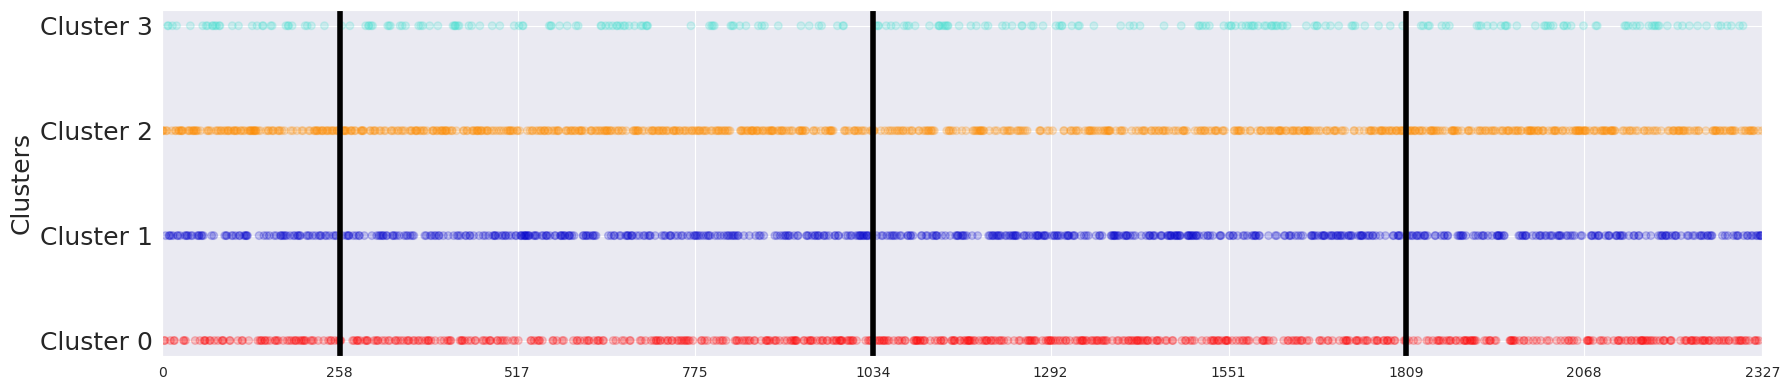

In [208]:
## Visualize the temporal changes in the clusters
## adapted from original code to deal with different size datasets

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Load the data (update the file name as needed)
y = np.loadtxt('km-n4-ft.txt')

# Dynamically generate x1 based on the size of y
x1 = np.arange(len(y))

# Define the colormap
colors = ['red', 'mediumblue', 'darkorange', 'turquoise']
cmap_name = 'my_list'
cmap = LinearSegmentedColormap.from_list(cmap_name, colors)

# Create the figure
fig = plt.figure(figsize=(18, 4))
ax = fig.add_subplot()

# Display size of x1 and y
print(f'x1 = {len(x1)} \n y = {len(y)}')

# Scatter plot
sc = ax.scatter(x1, y, c=y, cmap=cmap, s=30, alpha=0.2)

# Set y-ticks dynamically
unique_labels = np.unique(y).astype(int)
ax.set_yticks(unique_labels)
ax.set_yticklabels([f'Cluster {label}' for label in unique_labels], fontsize=18)
plt.ylabel('Clusters', fontsize=18)

# Dynamically set x-ticks
n_ticks = 10  # Define the number of x-ticks
x_ticks = np.linspace(0, len(x1) - 1, n_ticks, dtype=int)
# x_tick_labels = [f'Day {i}' for i in range(n_ticks)]
#x_tick_labels = ''
ax.set_xticks(x_ticks)
#ax.set_xticklabels(x_tick_labels, fontsize=16)

# Example vertical lines (adjust dynamically if needed)
vertical_lines = [x_ticks[1], x_ticks[4], x_ticks[7]]
for vline in vertical_lines:
    ax.axvline(x=vline, linewidth=4, color='black')

# Set x-limits (optionally zoom into a specific range)
plt.xlim(0, len(x1) - 1)  # Full range
# plt.xlim(980, 1020)  # Zoomed-in range (optional)

plt.tight_layout()

# Save the figure
fig.savefig('Temporal_Cluster_Changes.png', dpi=100)


In [209]:
### ORIGINAL CODE SPECIFIC TO THE ORIGINAL DATASET ###

# from matplotlib.colors import LinearSegmentedColormap

# y= np.loadtxt ('km-n4-ft.txt')
# fig= plt.figure(figsize=(18, 4))
# ax = fig.add_subplot()
# x1=list(range(0,2390))
# colors = ['red', 'mediumblue','darkorange','turquoise']
# cmap_name = 'my_list'
# cmap = LinearSegmentedColormap.from_list(cmap_name, colors)

# # display size of x1 and y
# #print(f'x1 = {len(x1)} \n y = {len(y)}')

# ax.scatter (x1, y, c=y, cmap=cmap, s= 30, alpha=0.2)
# ax.set_yticks ([0, 1, 2,3])
# ax.set_yticklabels (['EQ','CT1', 'ET','CT2'], fontsize=18)
# plt.ylabel('Clusters', fontsize= 18)

# ax.set_xticks ([0,175,417,708,996,1117,1425,1782,2142,2390])
# ax.set_xticklabels (['12 March','19 March','30 March','15 April','27 April','2 May','15 May','30 May','14 June','24 June'], fontsize=16)
# ax.axvline (x=174, linewidth=4, color='black')
# ax.axvline (x=996, linewidth=4, color='black')
# ax.axvline (x=2127, linewidth=4, color='black')

# plt.xlim (0,2390)
# plt.xlim (980,1020)
# plt.tight_layout()
# fig.savefig ( 'Temporal Cluster Changes.png', dpi= 100)

# Cluster-wise autoencoder input-output visualization

In [210]:
decoded_imgs[43,:,:,:].shape

torch.Size([1, 96, 128])

The following cell plots images from data locations specific to the original paper. It is included here for reference, but it is not currently correct for other data sets.

In [211]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
from matplotlib.pyplot import savefig
import matplotlib.gridspec as gridspec
import numpy as np

# Function to create a single spectrogram plot
def plot_spectrogram(ax, data, index, cmap='hot', vmin=-1, vmax=10, sr=8, freq_ticks=None, freq_labels=None, x_ticks=None, x_labels=None, ylabel=None, xlabel=None):
    """
    Plot a spectrogram on the provided axis.

    Args:
        ax: The axis to plot on.
        data: 3D array of spectrogram data.
        index: Index of the spectrogram slice to plot.
        cmap: Colormap for the plot.
        vmin: Minimum value for the color scale.
        vmax: Maximum value for the color scale.
        sr: Sampling rate.
        freq_ticks: Y-tick positions.
        freq_labels: Y-tick labels.
        x_ticks: X-tick positions.
        x_labels: X-tick labels.
        ylabel: Label for the y-axis.
        xlabel: Label for the x-axis.
    """
    librosa.display.specshow(data[index, :, :], cmap=cmap, antialiased=True, y_axis='linear', sr=sr, vmin=vmin, vmax=vmax, ax=ax)
    cbar = plt.colorbar(ax=ax, pad=0.03)
    cbar.ax.tick_params(labelsize=18, rotation=0)
    if freq_ticks and freq_labels:
        ax.set_yticks(freq_ticks)
        ax.set_yticklabels(freq_labels, fontsize=18)
    if x_ticks and x_labels:
        ax.set_xticks(x_ticks)
        ax.set_xticklabels(x_labels, fontsize=18)
    if ylabel:
        ax.set_ylabel(ylabel, fontsize=18)
    if xlabel:
        ax.set_xlabel(xlabel, fontsize=18)
